In [1]:
from mhkit import dolfyn as dlfn
from dolfyn.adp import api
from mhkit.dolfyn.rotate import api as ap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy.fft import fft, ifft
from datetime import datetime
import xarray as xr
import scipy.interpolate as interp
import utm
from mhkit.river.io import d3d 
from os.path import abspath, dirname, join, normpath, relpath
import netCDF4


C:\Users\eabrow\Codes\Tanana_test\dolfyn\dolfyn\velocity.py:12: AccessorRegistrationWarning: registration of accessor <class 'dolfyn.velocity.Velocity'> under name 'velds' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class Velocity():


In [2]:
ds_02 = api.read('data/tanana_transects_08_10_10_0_002_10-08-10_142214.PD0')
ds_03 = api.read('data/tanana_transects_08_10_10_0_003_10-08-10_143335.PD0')

ds_02_03= xr.merge([ds_02,ds_03])
ds_02_03


Reading file data/tanana_transects_08_10_10_0_002_10-08-10_142214.PD0 ...

Reading file data/tanana_transects_08_10_10_0_003_10-08-10_143335.PD0 ...


<xarray.Dataset>
Dimensions:              (time_gps: 1180, time: 1180, beam: 4, dir: 4, range: 47, x: 4, x*: 4, earth: 3, inst: 3)
Coordinates:
  * time_gps             (time_gps) datetime64[ns] 2010-08-10T22:28:17.200000...
  * time                 (time) datetime64[ns] 2010-08-10T14:28:15.559999942 ...
  * beam                 (beam) int32 1 2 3 4
  * dir                  (dir) <U3 'X' 'Y' 'Z' 'err'
  * range                (range) float64 0.57 0.82 1.07 ... 11.57 11.82 12.07
  * x                    (x) int32 1 2 3 4
  * x*                   (x*) int32 1 2 3 4
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
Data variables: (12/36)
    number               (time) float64 3.652e+03 3.653e+03 ... 4.904e+03
    builtin_test_fail    (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    c_sound              (time) float32 1.466e+03 1.466e+03 ... 1.466e+03
    depth                (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pitch                (time) float32 -0.1 -0.09 -0.21 -0.25 ... 0.2 0.07 0.56
    roll                 (time) float32 3.33 3.32 3.33 3.49 ... 2.24 2.65 2.33
    ...                   ...
    rtk_age_gps          (time_gps) float32 5.0 6.0 2.0 3.0 ... 6.0 2.0 3.0 3.0
    speed_over_grnd_gps  (time_gps) float32 0.03549 0.03395 ... 0.1096 0.1672
    dir_over_grnd_gps    (time_gps) float32 115.5 94.08 6.931 ... 160.5 182.1
    hdwtime_gps          (time_gps) datetime64[ns] 2010-08-10T14:28:15.559999...
    beam2inst_orientmat  (x, x*) float64 1.462 -1.462 0.0 ... -1.034 -1.034
    orientmat            (earth, inst, time) float64 -0.9037 -0.9025 ... 1.0 1.0
Attributes: (12/38)
    inst_make:                TRDI
    inst_type:                ADCP
    rotate_vars:              ['vel', 'vel_bt']
    has_imu:                  0
    prog_ver:                 10.16
    inst_model:               Rio Grande
    ...                       ...
    false_target_threshold:   50
    transmit_lag_m:           0.08
    bandwidth:                0
    sourceprog:               WINRIVER
    fs:                       11.11111111111111
    vel_gps_corrected:        0

In [3]:
data=utm.from_latlon(ds_02_03.latitude_gps, ds_02_03.longitude_gps, 6, 'W')
latitude=data[0]
longitude=data[1]
latitude

<xarray.DataArray (time_gps: 1180)>
array([400953.81301413, 400953.81301413, 400953.81301413, ...,
       400952.62816788, 400952.62816788, 400953.28310802])
Coordinates:
  * time_gps  (time_gps) datetime64[ns] 2010-08-10T22:28:17.200000047 ... 201...

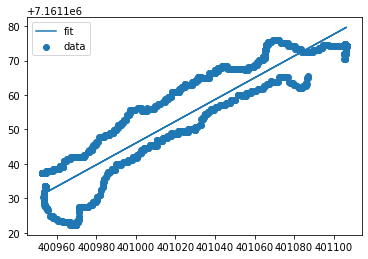

In [4]:
a,b = np.polyfit(latitude, longitude,1)
plt.scatter(latitude,longitude, label='data')
plt.plot(latitude,a*latitude+b, label= 'fit')
plt.legend()

In [5]:
# The ADCP transducers were measured to be 0.6 m from the feet of the lander
api.clean.set_range_offset(ds_02_03,0)
ds_02_03.range

<xarray.DataArray 'range' (range: 47)>
array([ 0.57,  0.82,  1.07,  1.32,  1.57,  1.82,  2.07,  2.32,  2.57,  2.82,
        3.07,  3.32,  3.57,  3.82,  4.07,  4.32,  4.57,  4.82,  5.07,  5.32,
        5.57,  5.82,  6.07,  6.32,  6.57,  6.82,  7.07,  7.32,  7.57,  7.82,
        8.07,  8.32,  8.57,  8.82,  9.07,  9.32,  9.57,  9.82, 10.07, 10.32,
       10.57, 10.82, 11.07, 11.32, 11.57, 11.82, 12.07])
Coordinates:
  * range    (range) float64 0.57 0.82 1.07 1.32 ... 11.32 11.57 11.82 12.07
Attributes:
    units:    m

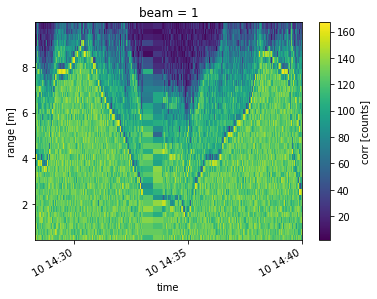

In [6]:
ds_02_03.corr.sel(beam=1, range=slice(0,10)).plot()
api.rotate2(ds_02_03, 'earth', inplace=True)
ds_02_03 = api.clean.correlation_filter(ds_02_03, thresh=40)

In [7]:
ap.set_declination(ds_02_03, 15.7, inplace=True) # 15.7 deg East for Nenana Alaska 

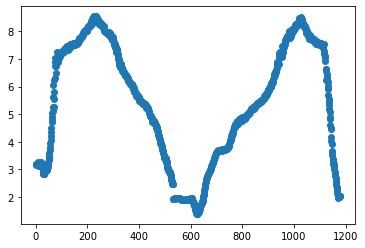

In [8]:
single_beam = ds_02_03.where(ds_02_03.dist_bt > 0 )
bottom=np.mean(single_beam.dist_bt,axis=0)
plt.scatter(np.linspace(0,np.size(bottom)-1,np.size(bottom)), bottom)
#a*latitude+b

In [9]:
bottom_filter= d3d.create_points(x=bottom.to_numpy(), y=ds_02_03.range.to_numpy(), waterdepth=1)
river_bottom_filter= []

for index, row in  bottom_filter.iterrows():
    if row['x'] > row['y']: 
        filter= 1
    
    else: 
        filter= float("nan")
    river_bottom_filter= np.append(river_bottom_filter, filter)



[0, 1, 2]


In [10]:
lat= np.tile(latitude, np.size( ds_02_03.range))
long= np.tile(longitude, np.size( ds_02_03.range))
depth =np.repeat( ds_02_03.range,np.size(latitude))
Point={'latitude': lat, 'longitude': long, 'waterdepth': depth}
points=pd.DataFrame(Point)
#plt.scatter(points.latitude, points.waterdepth)
#points

In [11]:
filter_points= d3d.create_points(x=np.linspace(0,np.size(bottom)-1,np.size(bottom)), y=ds_02_03.range.to_numpy(), waterdepth=1 )

[0, 1, 2]


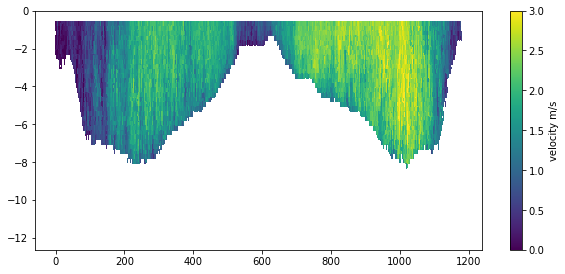

In [12]:
velocity= np.ravel(ds_02_03.vel[1, :,:])* river_bottom_filter

max_plot=0
min_plot=3

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    filter_points.x, 
    -filter_points.y, 
    velocity,
    vmin=min_plot,
    vmax=max_plot

)
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity m/s')

In [13]:
lat_points= np.tile(latitude, np.size( ds_02_03.range))
long_points= np.tile(a*latitude+b, np.size( ds_02_03.range))
depth_points =np.repeat( ds_02_03.range,np.size(latitude))

ADCP_points={'latitude': lat_points, 'longitude': long_points, 'waterdepth': depth_points}
ADCP_points=pd.DataFrame(ADCP_points)
#plt.scatter(ADCP_points.latitude, ADCP_points_longitude)
#ADCP_points

In [14]:
# Project velocity onto ideal tansect 
ADCP= pd.DataFrame()
#ADCP['East']= interp.griddata(points,np.ravel(ds_02_03.vel[0,:,:]),ADCP_points)
ADCP['North']= interp.griddata(points,velocity,ADCP_points, method='linear')
#ADCP['Vertical']= interp.griddata(points,np.ravel(ds_02_03.vel[2,:,:]),ADCP_points)

(400960.0, 401090.0)

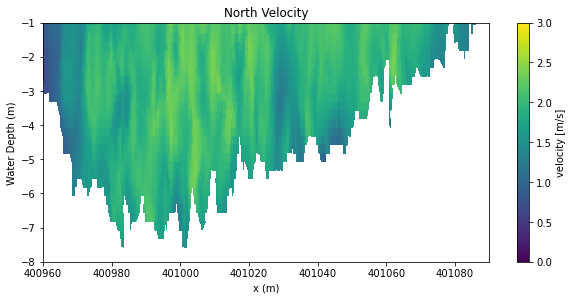

In [35]:
max_plot=3
min_plot=0

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    ADCP_points.latitude, 
    -ADCP_points.waterdepth, 
     ADCP.North,
    vmin=min_plot,
    vmax=max_plot
)

plt.xlabel('x (m)')
plt.ylabel('Water Depth (m)')
plt.title('North Velocity')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
plt.ylim([-8,-1])
plt.xlim([400960,401090])

In [16]:
# Simulated data
# Downloading Data
d3d_data = netCDF4.Dataset('data/tanana50_map.nc')

In [17]:
# Printing variable and description
for var in d3d_data.variables.keys():
    try: 
        d3d_data[var].long_name
    except:
        print(f'"{var}"')        
    else:
        print(f'"{var}": {d3d_data[var].long_name}')

"mesh2d_enc_x": x-coordinate
"mesh2d_enc_y": y-coordinate
"mesh2d_enc_node_count": count of coordinates in each instance geometry
"mesh2d_enc_part_node_count": count of nodes in each geometry part
"mesh2d_enc_interior_ring": type of each geometry part
"mesh2d_enclosure_container"
"Mesh2D"
"NetNode_x": x-coordinate
"NetNode_y": y-coordinate
"projected_coordinate_system"
"NetNode_z": bed level at net nodes (flow element corners)
"NetLink": link between two netnodes
"NetLinkType": type of netlink
"NetElemNode": mapping from net cell to net nodes (counterclockwise)
"NetElemLink": mapping from net cell to its net links (counterclockwise)
"NetLinkContour_x": list of x-contour points of momentum control volume surrounding each net/flow link
"NetLinkContour_y": list of y-contour points of momentum control volume surrounding each net/flow link
"NetLink_xu": x-coordinate of net link center (velocity point)
"NetLink_yu": y-coordinate of net link center (velocity point)
"BndLink": netlinks that co

In [18]:
ADCP_poinmts_xy= ADCP_points.rename(columns={"latitude": "x", "longitude": "y"})

In [19]:
variables= ['ucy']
D3d= d3d.variable_interpolation(d3d_data, variables, points= ADCP_poinmts_xy)#,edges=  'nearest')

points provided


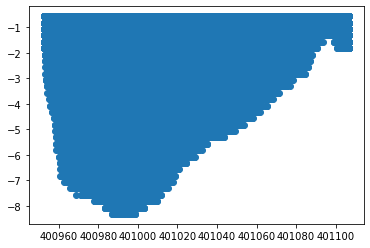

In [20]:
plt.scatter(ADCP_points.latitude*river_bottom_filter,  -ADCP_points.waterdepth*river_bottom_filter)

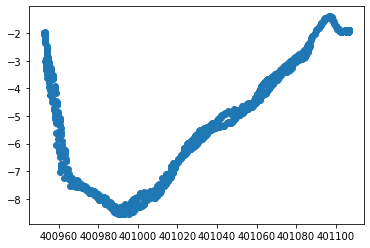

In [42]:
plt.scatter(latitude, -bottom)


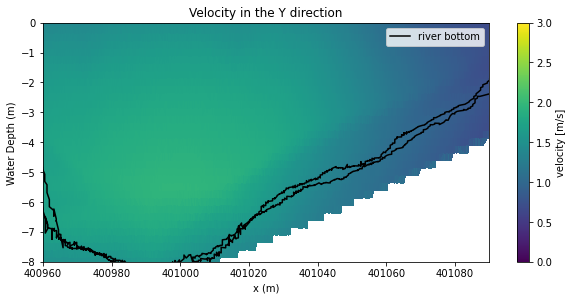

In [47]:
max_plot=3
min_plot=0

# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot = plt.tripcolor(
    D3d.x, 
    -D3d.waterdepth+1.7, 
    D3d.ucy,
    vmin=min_plot,
    vmax=max_plot

)

plt.xlabel('x (m)')
plt.ylabel('Water Depth (m)')
plt.title('Velocity in the Y direction')
cbar= plt.colorbar(contour_plot)
cbar.set_label('velocity [m/s]')
plt.ylim([-8,0])
plt.xlim([400960,401090])
#plt.scatter(ADCP_points.latitude*river_bottom_filter,  -ADCP_points.waterdepth*river_bottom_filter)
plt.plot(latitude, -bottom,'k', label= 'river bottom')
plt.legend()

In [22]:
# L1

#north 
L1_north= abs(ADCP.North-D3d.ucy)

#East 
#L1_east= abs(ADCP.East-D3D.ucx) / ADCP.East

#Vertical 
#L1_vert= abs(ADCP.Vertical-D3D.ucz) / ADCP.Vertical


MAE= np.sum(L1_north)/np.size(L1_north)
MAE

0.14468451703973306

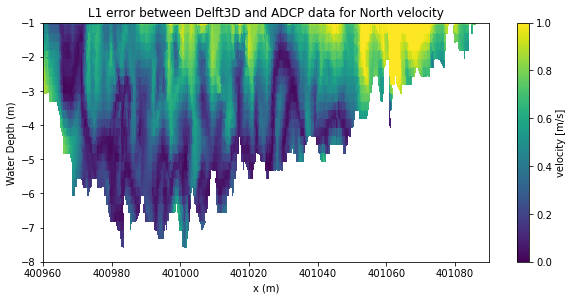

In [29]:
max_plot=1
min_plot=0
# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot_L1 = plt.tripcolor(
    D3d.x, 
    -D3d.waterdepth, 
    L1_north,
    vmin=min_plot,
    vmax=max_plot
)

plt.xlim([400960,401090])
plt.ylim([-8,-1])
plt.xlabel('x (m)')
plt.ylabel('Water Depth (m)')
plt.title('L1 error between Delft3D and ADCP data for North velocity')
cbar= plt.colorbar(contour_plot_L1)
cbar.set_label('velocity [m/s]')

0.09715571308148355


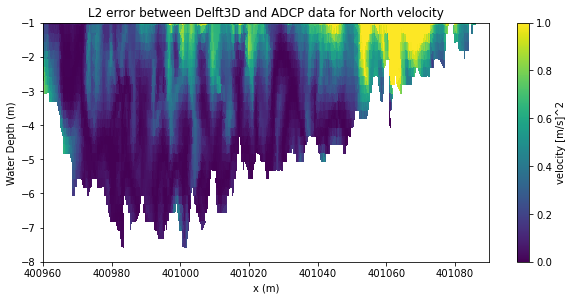

In [30]:
# L2 

L2_north= (ADCP.North-D3d.ucy)**2

##East 
#(ADCP.East-D3D.ucx)^2 / ADCP.East

##Vertical 
#(ADCP.Vertical-D3D.ucz)^2 / ADCP.Vertical


RMS=np.sum(L2_north)/np.size(L2_north)

print(RMS)

max_plot=1
min_plot=0
# Plotting 
plt.figure(figsize=(10,4.4))
contour_plot_L2 = plt.tripcolor(
    D3d.x, 
    -D3d.waterdepth, 
    L2_north,
    vmin=min_plot,
    vmax=max_plot
)

plt.xlim([400960,401090])
plt.ylim([-8,-1])
plt.xlabel('x (m)')
plt.ylabel('Water Depth (m)')
plt.title('L2 error between Delft3D and ADCP data for North velocity')
cbar= plt.colorbar(contour_plot_L1)
cbar.set_label('velocity [m/s]^2')

In [25]:
# L inf

L_inf= max(L1_north)
L_inf

1.4719321121752387